Labeled Revision Mock
===

Mocking labeled revisions so that rev-scoring can be applied.

See also: CrossTimeSampling2.ipynb

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [10]:
import mwapi
import mwxml
import mwxml.utilities
import mwcli
import mwreverts
import oresapi
import mwparserfromhell

In [11]:
import os
import requests
from tqdm import tqdm
import bz2
import gzip
import json
import re
import hashlib
from datetime import datetime
import nltk
import scipy.stats
import para
from itertools import groupby
from collections import Counter
import time

In [4]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
git_root_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback'

In [5]:
labeled_revisions_filepath = os.path.join(git_root_dir, "data/raw/editquality/datasets/enwiki.labeled_revisions.20k_2015.json")
assert os.path.exists(labeled_revisions_filepath)

In [92]:
!head -n 3 {labeled_revisions_filepath}

{"rev_id": 644933637, "auto_labeled": false, "damaging": false, "goodfaith": true, "autolabel": {}}
{"rev_id": 629393521, "auto_labeled": false, "damaging": false, "goodfaith": true, "autolabel": {}}
{"rev_id": 655365754, "auto_labeled": false, "damaging": false, "goodfaith": true, "autolabel": {}}


In [6]:
revisions_features_filepath = os.path.join(git_root_dir, "data/raw/editquality/datasets/enwiki.labeled_revisions.20k_2015.damaging.tsv")
assert os.path.exists(labeled_revisions_filepath)

In [7]:
training_data_rev_ids = []
with open(labeled_revisions_filepath, 'r') as infile:
    for line in infile:
        rev = json.loads(line)
        rev_id = rev['rev_id']
        training_data_rev_ids.append(rev_id)
len(training_data_rev_ids)

19898

In [ ]:
# labeled_revisions.20k_2015 text retrieval
# This approach uses mwapi, but it seems not to work for some reason
assert False
session = mwapi.Session("https://en.wikipedia.org/w/api.php", 
                        timeout=5.0,
                        user_agent="LabeledRevisionMock/0.0 (github.com/levon003/wiki-ores-feedback; levon003@umn.edu) mwapi/0.5.1")
splits = np.array_split(training_data_rev_ids, int(len(training_data_rev_ids) / 50) + 1)
results = []
for rev_id_list in tqdm(splits):
    assert len(rev_id_list) <= 50
    params = {
        'action': 'query',
        'format': 'json',
        'formatversion': '2',
        'revids': "|".join([str(rev_id) for rev_id in rev_id_list]),
        'prop': 'revisions',
        'rvprop': 'ids|timestamp|user|comment|content|tags',
        'rvslots': 'main',
#        'maxlag': 5
    }
    awaiting_result = True
    while awaiting_result:
        try:
            result = session.get(params)
        except requests.exceptions.Timeout as timeout_ex:
            print(timeout_ex)
            print("Timeout waiting for response. Waiting and trying again...")
            time.sleep(5)
        except mwapi.errors.APIError as ex:
            print(ex)
            print("Maxlag at:", datetime.now())
            # https://www.mediawiki.org/wiki/Manual:Maxlag_parameter
            print("Server response exceeded maxlag time; waiting before retry.")
            time.sleep(5)
        results.append(result)
    time.sleep(0.01)

In [ ]:
# labeled_revisions.20k_2015 text retrieval
headers = {
    'User-Agent': 'LabeledRevisionMock/0.0 (github.com/levon003/wiki-ores-feedback; levon003@umn.edu) requests/2.22.0',
    'From': 'levon003@umn.edu'
}
splits = np.array_split(training_data_rev_ids, int(len(training_data_rev_ids) / 50) + 1)
results = []
for rev_id_list in tqdm(splits):
    assert len(rev_id_list) <= 50
    params = {
        'action': 'query',
        'format': 'json',
        'formatversion': '2',
        'revids': "|".join([str(rev_id) for rev_id in rev_id_list]),
        'prop': 'revisions',
        'rvprop': 'ids|timestamp|user|comment|content|tags',
        'rvslots': 'main',
        'maxlag': 5
    }
    awaiting_result = True
    while awaiting_result:
            response = requests.get("https://en.wikipedia.org/w/api.php", params=params, headers=headers)
            if response.ok:
                result = response.json()
                if 'error' in result:
                    print(result['error'])
                    print("Maxlag at:", datetime.now())
                    # https://www.mediawiki.org/wiki/Manual:Maxlag_parameter
                else:
                    results.append(result)
                    break
            else:
                print("Error:", response)
            print("Server response error; waiting before retry.")
            time.sleep(5)
    time.sleep(0.01)  # this is completely unnecessary I think; sequential requests without waiting is fine

In [25]:
# all batches complete?
assert np.all([result['batchcomplete'] for result in results])

In [26]:
results = [result['query'] for result in results]
len(results)

398

In [60]:
# Save the retrieved data
working_dir = os.path.join(git_root_dir, "data/derived/labeled-revs")
os.makedirs(working_dir, exist_ok=True)
output_filepath = os.path.join(working_dir, 'labeled_revisions.20k_2015.content.ndjson')
with open(output_filepath, 'w') as outfile:
    for result in results:
        outfile.write(json.dumps(result) + "\n")
print("Finished.")

Finished.


In [61]:
# Load in the labeled revisions content data
labeled_revs_dir = os.path.join(git_root_dir, "data/derived/labeled-revs")
labeled_revs_filepath = os.path.join(labeled_revs_dir, 'labeled_revisions.20k_2015.content.ndjson')
results = []
with open(labeled_revs_filepath, 'r') as infile:
    for line in infile:
        result = json.loads(line)
        results.append(result)
len(results)

398

In [62]:
results[0].keys()

dict_keys(['badrevids', 'pages'])

In [63]:
# 520 total "bad" rev_ids, with bad revisions appearing in 73% of query batches
len(results[0]['badrevids'].keys())
badrevids_count_list = []
badrevids_total = 0
for result in results:
    if 'badrevids' in result:
        badrevids_count = len(result['badrevids'].keys())
        badrevids_total += badrevids_count
        badrevids_count_list.append(badrevids_count)
    else:
        badrevids_count_list.append(0)
badrevids_count_list = np.array(badrevids_count_list)
badrevids_total, np.sum(badrevids_count_list > 0) / len(results)

(520, 0.7336683417085427)

In [64]:
revision_timestamps = []
for result in results:
    for page in result['pages']:
        for rev in page['revisions']:
            page_id = page['pageid']
            rev_id = rev['revid']
            rev_timestamp_str = rev['timestamp']
            rev_timestamp = int(datetime.strptime(rev_timestamp_str, "%Y-%m-%dT%H:%M:%SZ").timestamp())
            revision_timestamps.append(rev_timestamp)
revision_timestamps = np.array(revision_timestamps)

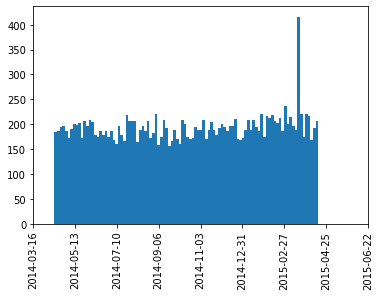

In [65]:
plt.hist(revision_timestamps, bins=100)

xticks, _ = plt.xticks()
plt.xticks(xticks, 
           [datetime.utcfromtimestamp(xtick).strftime("%Y-%m-%d") for xtick in xticks], 
           rotation='vertical')
plt.show()

In [66]:
days = [int(datetime.utcfromtimestamp(rt).strftime("%Y%m%d")) for rt in revision_timestamps]
mc = Counter(days).most_common()

In [67]:
for day, count in sorted(mc, key=lambda tup: tup[0])[:10]:
    print(f"{day} ({count}) " + "="*count)
print("<snip>")
for day, count in sorted(mc, key=lambda tup: tup[0])[-10:]:
    print(f"{day} ({count}) " + "="*count)

20140415 (36) ====================================
20140416 (48) ================================================
20140417 (55) =======================================================
20140418 (57) =========================================================
20140419 (45) =============================================
20140420 (52) ====================================================
20140421 (53) =====================================================
20140422 (58) ==========================================================
20140423 (57) =========================================================
20140424 (54) ======================================================
<snip>
20150406 (55) =======================================================
20150407 (50) ==================================================
20150408 (60) ============================================================
20150409 (50) ==================================================
20150410 (44) =======================================

In [68]:
mc[:10]

[(20150320, 266),
 (20150301, 79),
 (20150210, 77),
 (20150221, 75),
 (20141031, 72),
 (20140520, 71),
 (20140519, 71),
 (20150331, 70),
 (20140729, 70),
 (20141014, 69)]

In [74]:
features_df = pd.read_csv(revisions_features_filepath, sep='\t', header=0)
len(features_df)

19348

In [77]:
rev_list = []
revisions_with_cache_filepath = os.path.join(git_root_dir, "data/raw/editquality/datasets/enwiki.labeled_revisions.w_cache.20k_2015.json")
with open(revisions_with_cache_filepath, 'r') as infile:
    for line in infile:
        rev = json.loads(line)
        rev_list.append({
            'rev_id': rev['rev_id'],
            'damaging': rev['damaging'],
            'goodfaith': rev['goodfaith']
        })
df = pd.DataFrame(rev_list)
len(df)

19348

In [78]:
df.head()

,rev_id,damaging,goodfaith
0,644933637,False,True
1,629393521,False,True
2,655365754,False,True
3,616502017,False,True
4,651762922,False,True


In [83]:
df = pd.concat([df, features_df], axis=1)

In [84]:
df.head()

,rev_id,damaging,goodfaith,feature.revision.page.is_articleish,feature.revision.page.is_mainspace,feature.revision.page.is_draftspace,feature.log((wikitext.revision.parent.chars + 1)),feature.log((len(<datasource.tokenized(datasource.revision.parent.text)>) + 1)),feature.log((len(<datasource.wikitext.revision.parent.words>) + 1)),feature.log((len(<datasource.wikitext.revision.parent.uppercase_words>) + 1)),...,feature.english.dictionary.revision.diff.dict_word_prop_delta_sum,feature.english.dictionary.revision.diff.dict_word_prop_delta_increase,feature.english.dictionary.revision.diff.dict_word_prop_delta_decrease,feature.english.dictionary.revision.diff.non_dict_word_delta_sum,feature.english.dictionary.revision.diff.non_dict_word_delta_increase,feature.english.dictionary.revision.diff.non_dict_word_delta_decrease,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_sum,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_increase,feature.english.dictionary.revision.diff.non_dict_word_prop_delta_decrease,damaging
0,644933637,False,True,False,False,False,11.487669,9.673949,8.289037,2.890372,...,2.597872,2.597872,0.0,12,12,0,11.027027,11.027027,0.0,False
1,629393521,False,True,True,True,False,9.782336,8.767173,7.884953,3.218876,...,0.000000,0.000000,0.0,0,0,0,0.000000,0.000000,0.0,False
2,655365754,False,True,False,False,False,8.696009,7.963112,6.218600,1.098612,...,0.000000,0.000000,0.0,0,0,0,0.000000,0.000000,0.0,False
3,616502017,False,True,True,True,False,9.205629,8.144969,7.152269,3.496508,...,1.000000,1.000000,0.0,0,0,0,0.000000,0.000000,0.0,False
4,651762922,False,True,False,False,False,7.603898,6.356108,5.323010,2.484907,...,16.596429,16.596429,0.0,7,7,0,5.342857,5.342857,0.0,False


In [89]:
rev_ids_with_content = set()
for result in results:
    for page in result['pages']:
        for rev in page['revisions']:
            rev_id = rev['revid']
            rev_ids_with_content.add(rev_id)
df['has_content'] = df.rev_id.map(lambda rev_id: rev_id in rev_ids_with_content)
len(rev_ids_with_content)

19378

In [90]:
f"{np.sum(df.has_content)} / {len(df)} ({np.sum(df.has_content) / len(df)*100:.2f}%) training revisions have associated content."

'19344 / 19348 (99.98%) training revisions have associated content.'

### Construct rev_id sample

In [96]:
raw_data_dir = "/export/scratch2/wiki_data"
derived_data_dir = os.path.join(git_root_dir, "data", "derived")

In [97]:
# read in the sample dataframe
revision_sample_dir = os.path.join(derived_data_dir, 'revision_sample')
sample1_filepath = os.path.join(revision_sample_dir, 'sample1_1M.pkl')
rev_df = pd.read_pickle(sample1_filepath)
len(rev_df)

1000000

In [99]:
rev_df.head()

,page_id,rev_id,rev_timestamp,is_revert_target,is_reverted,is_reverting,is_sample_eligible,prev_rev_id,next_rev_id,prev_rev_timestamp,next_rev_timestamp,reverted_rev_ids,reverting_rev_id,reverting_rev_timestamp
29999548,9516095,846835190,1529576038,0,0,0,True,846835009,850539656,1529575914,1531769146,[],-1,-1
12474631,876872,923997118,1572595746,0,0,0,True,923211396,924618182,1572162918,1572930319,[],-1,-1
62536703,53465104,867368228,1541425108,0,0,0,True,867366487,867663184,1541423455,1541590304,[],-1,-1
73902987,60096152,888337768,1552936050,0,0,0,True,888337457,888338754,1552935890,1552936561,[],-1,-1
43843955,28063274,917010365,1569117229,0,0,0,True,915190631,-1,1568247118,-1,[],-1,-1


In [94]:

mock_template = '{"rev_id": %d, "auto_labeled": false, "damaging": false, "goodfaith": true, "autolabel": {}}'


'{"rev_id": 23, "auto_labeled": false, "damaging": false, "goodfaith": true, "autolabel": {}}'

In [101]:
working_dir = os.path.join(git_root_dir, "data/derived/labeled-revs")
mock_rev_filepath = os.path.join(working_dir, "sample1.mock.json")
with open(mock_rev_filepath, 'w') as outfile:
    for rev_id in rev_df.rev_id:
        line = mock_template % rev_id
        outfile.write(line + "\n")
print("Finished.")

Finished.


In [102]:
!head -n 3 {mock_rev_filepath}

{"rev_id": 846835190, "auto_labeled": false, "damaging": false, "goodfaith": true, "autolabel": {}}
{"rev_id": 923997118, "auto_labeled": false, "damaging": false, "goodfaith": true, "autolabel": {}}
{"rev_id": 867368228, "auto_labeled": false, "damaging": false, "goodfaith": true, "autolabel": {}}


In [103]:
mock_rev_filepath

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/labeled-revs/sample1.mock.json'

From the `revscoring` repo, using the `wiki-revscoring` conda environment, I ran:

```
cat /export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/labeled-revs/sample1.mock.json | revscoring extract editquality.feature_lists.enwiki.damaging editquality.feature_lists.enwiki.goodfaith --host https://en.wikipedia.org --extractors 32 --verbose > /export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/labeled-revs/sample1.mock.w_cache.json

revscoring dump_cache --input /export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/labeled-revs/sample1.mock.w_cache.json --output /export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/labeled-revs/sample1.mock.damaging.tsv --verbose editquality.feature_lists.enwiki.damaging damaging

```

In [104]:
# copied from bash commands above
mock_features_filepath = "/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/labeled-revs/sample1.mock.damaging.tsv"

In [105]:
mock_features_df = pd.read_csv(mock_features_filepath, sep='\t', header=0)
len(mock_features_df)

458449

In [1]:
features_df.shape

NameError: name 'features_df' is not defined